In [276]:
#https://nilearn.github.io/dev/glm/second_level_model.html
# Reminder : Multiple comparisons correction

import os
import nilearn 
import numpy as np 
import pandas as pd
import nibabel as nib

import matplotlib.pyplot as plt
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.datasets import fetch_localizer_contrasts




# Init variables
init_folder='/home/traaffneu/margal/code/multirat_se/script/'
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'

# Data path
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path = '/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'

# Paths for the directories
output_dir = '/project/4180000.19/multirat_stim/rabies_test/second_level_analysis/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)



df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]



In [ ]:
cofounders_list = pd.DataFrame(columns=['subject_label', 'field_strength'])
subjects_label_list = pd.DataFrame(columns=['subject_label'])

for index in range (1, 20):
    
    n_subjects = 20  

    subject_label = int(np.matrix(df.iloc[index]['rat.sub']).A[0])
    field_strength = np.matrix(df.iloc[index]['MRI.field.strength']).A[0]
    cofounders = pd.DataFrame({'subject_label': subject_label,'field_strength': field_strength})

    cofounders_list = cofounders_list.append(cofounders, ignore_index=True)
    subjects_label_list = subjects_label_list.append({'subject_label': subject_label}, ignore_index=True)

# print(subjects_label_list)
# print(cofounders_list)


design_matrix = make_second_level_design_matrix(subjects_label_list['subject_label'], cofounders_list)      #extract subject_label column from subject_label_list dataframe -> convert as an array
print(design_matrix)

# ----------------------------------------------------------------





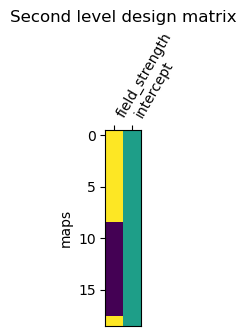

In [274]:

ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12)
ax.set_ylabel("maps")
plt.tight_layout()
plt.show()

In [ ]:
for i in range(1, 15)
    subj_num=str(df.iloc[i]['rat.sub'])[:-2]
    print(subj_num)

    subject_path = analysis_folder+'/sub-0{}_ses-1/bold_datasink/commonspace_bold/_scan_info_subject_id0{}.session1_split_name_sub-0{}_ses-1_T2w/_run_1/sub-0{}_ses-1_run-1_bold_combined.nii.gz'.format(subj_num, subj_num, subj_num, subj_num)

n_subjects = 16
data = fetch_localizer_contrasts(["left vs right button press"],
                                 n_subjects,
                                 get_tmaps=True,
                                 legacy_format=False)



In [278]:

second_level_input = data["cmaps"]
design_matrix = pd.DataFrame(
    [1] * len(second_level_input),
    columns=["intercept"],


second_level_model = SecondLevelModel(smoothing_fwhm=8.0)
second_level_model = second_level_model.fit(second_level_model,
                                            design_matrix=design_matrix)